In [18]:
!wget https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip

In [19]:
!unzip kagglecatsanddogs_5340.zip

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import os
import tqdm
import random
import PIL
from keras.preprocessing.image import load_img
warnings.filterwarnings('ignore')

In [22]:
# cat, dog = 1, 0
data = pd.DataFrame()
path_lst=[]
type_lst=[]
for pettype in os.listdir("PetImages"):
  for img in os.listdir("PetImages/"+pettype):
    path_lst.append("PetImages/"+pettype+'/'+img)
    type_lst.append('1' if pettype=='Cat' else '0')
    
data['type']=type_lst
data['path']=path_lst

In [23]:
data.head()

,type,path
0,0,PetImages/Dog/4700.jpg
1,0,PetImages/Dog/7282.jpg
2,0,PetImages/Dog/3769.jpg
3,0,PetImages/Dog/10493.jpg
4,0,PetImages/Dog/2667.jpg


In [24]:
df = data[data['path'].str.endswith('.jpg')]
df

,type,path
0,0,PetImages/Dog/4700.jpg
1,0,PetImages/Dog/7282.jpg
2,0,PetImages/Dog/3769.jpg
3,0,PetImages/Dog/10493.jpg
4,0,PetImages/Dog/2667.jpg
...,...,...
24997,1,PetImages/Cat/1748.jpg
24998,1,PetImages/Cat/5059.jpg
24999,1,PetImages/Cat/2016.jpg
25000,1,PetImages/Cat/10333.jpg


In [25]:
df['type'].value_counts()

0    12500
1    12500
Name: type, dtype: int64

In [26]:
failed = []
for img in df['path']:
    try:
        image = PIL.Image.open(img)
    except:
        failed.append(img)
failed

['PetImages/Dog/11702.jpg', 'PetImages/Cat/666.jpg']

In [27]:
df = df[~df['path'].isin(failed)]

In [28]:
df= df.reset_index(drop=True)

In [29]:
df['type'].value_counts()

0    12499
1    12499
Name: type, dtype: int64

In [30]:
plt.figure(figsize=(10,25))
dog_path = df[df['type']==0]['path']

for idx, file in enumerate(dog_path[100:104]):
    plt.subplot(2,2, idx + 1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title('Dogs')
    plt.axis('off')

<Figure size 720x1800 with 0 Axes>

In [31]:
plt.figure(figsize=(10,25))
cat_path = df[df['type']==1]['path']

for idx, file in enumerate(cat_path[:4]):
    plt.subplot(2,2, idx + 1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title('Dogs')
    plt.axis('off')

<Figure size 720x1800 with 0 Axes>

In [32]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.25, random_state=10)

In [33]:
from keras.preprocessing.image import ImageDataGenerator
train_setting = ImageDataGenerator(
    rescale = 1./255, 
    rotation_range = 50, 
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    vertical_flip = True,
    fill_mode = 'nearest'
)

val_setting = ImageDataGenerator(rescale = 1./255)

train_iterator = train_setting.flow_from_dataframe(
    train, 
    x_col='path', 
    y_col='type', 
    target_size=(256,256), 
    batch_size=512, 
    class_mode='binary'
)

val_iterator = val_setting.flow_from_dataframe(
    test, 
    x_col='path', 
    y_col='type', 
    target_size=(256,256), 
    batch_size=512, 
    class_mode='binary'
)

Found 18748 validated image filenames belonging to 2 classes.
Found 6250 validated image filenames belonging to 2 classes.


In [34]:
import keras
from keras import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, MaxPooling2D, Dropout

In [39]:
model = Sequential([
            Conv2D(24, (3,3), activation='relu', input_shape=(256,256,3)),
            MaxPool2D((2,2)),
            Conv2D(48, (3,3), activation='relu'),
            MaxPool2D((2,2)),
            Conv2D(96, (3,3), activation='relu'),
            MaxPool2D((2,2)),
            Flatten(),
            Dense(1, activation='sigmoid')
  ])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# model.summary()


In [40]:
history = model.fit(train_iterator, epochs=20, validation_data=val_iterator)

Epoch 1/20
37/37 [==============================] - 320s 8s/step - loss: 0.6950 - accuracy: 0.5609 - val_loss: 0.6541 - val_accuracy: 0.6091
Epoch 2/20
37/37 [==============================] - 300s 8s/step - loss: 0.6201 - accuracy: 0.6580 - val_loss: 0.5989 - val_accuracy: 0.6877
Epoch 3/20
37/37 [==============================] - 299s 8s/step - loss: 0.5970 - accuracy: 0.6772 - val_loss: 0.5711 - val_accuracy: 0.7098
Epoch 4/20
37/37 [==============================] - 302s 8s/step - loss: 0.5793 - accuracy: 0.6954 - val_loss: 0.5581 - val_accuracy: 0.7197
Epoch 5/20
37/37 [==============================] - 300s 8s/step - loss: 0.5763 - accuracy: 0.6961 - val_loss: 0.5648 - val_accuracy: 0.7061
Epoch 6/20
37/37 [==============================] - 301s 8s/step - loss: 0.5570 - accuracy: 0.7132 - val_loss: 0.5252 - val_accuracy: 0.7352
Epoch 7/20
37/37 [==============================] - 299s 8s/step - loss: 0.5428 - accuracy: 0.7222 - val_loss: 0.5296 - val_accuracy: 0.7336
Epoch 8/20
37

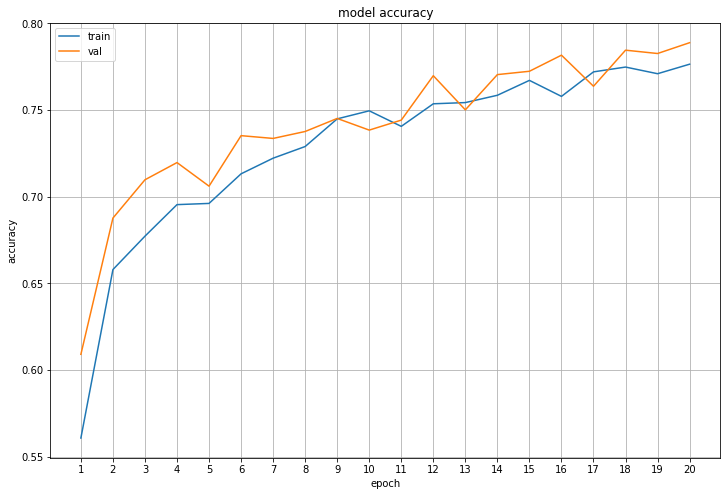

In [50]:
plt.figure(figsize=(12,8))
plt.plot(list(range(1,21)),history.history['accuracy'])
plt.plot(list(range(1,21)),history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.xticks(range(1, 21))
plt.grid('on')
plt.show()

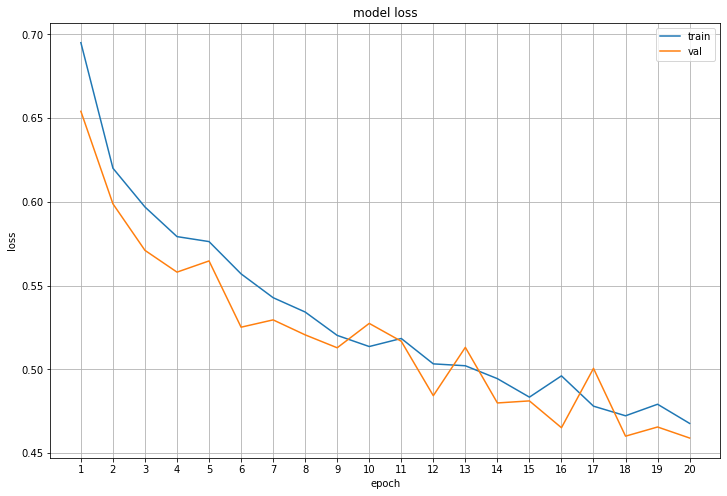

In [53]:
plt.figure(figsize=(12,8))
plt.plot(list(range(1,21)),history.history['loss'])
plt.plot(list(range(1,21)),history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.xticks(range(1, 21))
plt.grid('on')
plt.show()